In [1]:
# Useful imports
import numpy as np, matplotlib.pyplot as plt
import sys; sys.path.append('./')
import models
from data_loader import DataLoader
import emcee, corner
from sklearn.covariance import EmpiricalCovariance
import numpy.linalg as lin
import seaborn as sns

--------------
# Code to change!

In [2]:
# Which data to load?
# E_min : [0.676, 0.84 , 1.269, 1.741, 2.12 , 2.609, 2.609, 3.586, 4.332, 5.475]
# E_max : [0.706, 0.868, 1.292, 1.759, 2.137, 2.624, 2.624, 3.598, 4.342, 5.484]
E_min = 0.676 # MeV
E_max = 2.624 # MeV
which_data = 'som'

# Select the parameterization
# parameterization = 'init-f-wave'
parameterization = 'bs_C'

# Use theory cov?
use_theory_cov = True

# # Information about the sampling
# n_burn = 50000
# n_steps = 200000

# Samples file
file_name = './11_06_2023/run1/samples_1.npz'

# Plot things?
plot_trace = True
plot_prob = False


# Correlation matrix (only ERPs vs. include all ERPs + norm)
just_ERPs = True

# Plot cross sections?
# If true, this takes a long time if they are not precomputed
plot_cs = False
# Cross sections file (If I precompute them)
cross_section_file = None


In [3]:
loader = DataLoader(E_min, E_max, which_data)

data = loader.get_data()
norm_group = loader.get_normalization_grouping()
gauss_prior_f = loader.get_normalization_prior_info()

In [4]:
# # # Set the parameter bounds and initialize the model
if parameterization == 'standard':
    labels = ['A0', 'r0', 'A1+', 'r1+', 'P1+', 'A1-', 'r1-', 'P1-']
    sys.stderr.write('No Longer Supported....')
    sys.exit(-1)
elif parameterization == 'bound_state':
    labels = ['A0', 'r0', 'r1+', 'P1+', 'r1-', 'P1-']
    param_bounds = np.array([[-0.02, 0.06], [-3, 3], [-1, 1], [-6, 6], [-1, 1], [-6, 6]])
    params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [0.0, 0.1], [0.0, 1.6], [0.0, 0.1], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    sys.stderr.write('Not implemented yet...')
    sys.exit(-1)
elif parameterization == 'bs_C':
    labels = ['A0', 'r0', 'C1+^2', 'P1+', 'C1-^2', 'P1-']
    param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6]])
    params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = models.BS_C(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)
elif parameterization == 'init-f-wave':
    labels = ['A0', 'r0', 'C1+^2', 'P1+', 'C1-^2', 'P1-', 'r3+']
    param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6], [-3, 0]])
    params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6], [-0.5, 1]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = models.F_Wave_AR(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)

# Add normalization labels
for i in range(0, int(np.max(norm_group) + 1)):
    labels.append('f_{}'.format(i))

In [5]:
# Load in the samples
all_samples = np.load(file_name)['arr_0']

samples_not_flat = all_samples[0] # Just the T = 0 samples

# # Reshape the samples
# len0, len1, len2 = samples_not_flat.shape
# samples = np.reshape(samples_not_flat, (len0 * len1, len2))

In [6]:
# # Look at the variances within each chain to determine if the walker is moving enough or if it is stuck.
# within_chain_means = np.mean(samples_not_flat[:, :, :], axis = 0)

# # Create an empty array of the within chain variances
# within_chain_var = np.empty(within_chain_means.shape)

# # Run a for loop across all walkers to compute the within chain variance
# for i in range(0, within_chain_means.shape[0]):
#     within_chain_var[i, :] = np.sum(np.square(within_chain_means[i, :] - samples_not_flat[:, i, :]), axis = 0) / (samples_not_flat.shape[0] // 2)

# # Get the typical within chain variance W for each parameter
# W = np.median(within_chain_var, axis = 0)


# # Now we need to loop over each chain for each parameter to see how it compares to the typical variance
# bad_indices = []
# ratios = np.empty(within_chain_means.shape)
# # Loop over each parameter
# for i in range(0, within_chain_means.shape[1]):
#     # Loop over the walkers
#     for j in range(0, within_chain_means.shape[0]):
#         ratio = np.sum(within_chain_var[j, i] / W[i]) / within_chain_means.shape[1]
#         ratios[j, i] = ratio

# # Sum along each parameter, this value should be very close to 1.0. Select out the bad indices
# total_normalized_ratios = np.sum(ratios, axis = 1)
# bad_indices = np.where(total_normalized_ratios <= 0.9)[0]
# print('Found {} bad walkers at indices:'.format(bad_indices.shape[0]))
# print(bad_indices)

# if bad_indices.shape[0] != 0:
#     # Remove the bad walkers
#     samples_not_flat = np.delete(samples_not_flat, bad_indices, axis = 1)

In [9]:
# Flatten the samples and log-prob
len0, len1, len2 = samples_not_flat.shape
samples = np.reshape(samples_not_flat, (len0 * len1, len2))
print(samples.shape)

(1300000, 13)


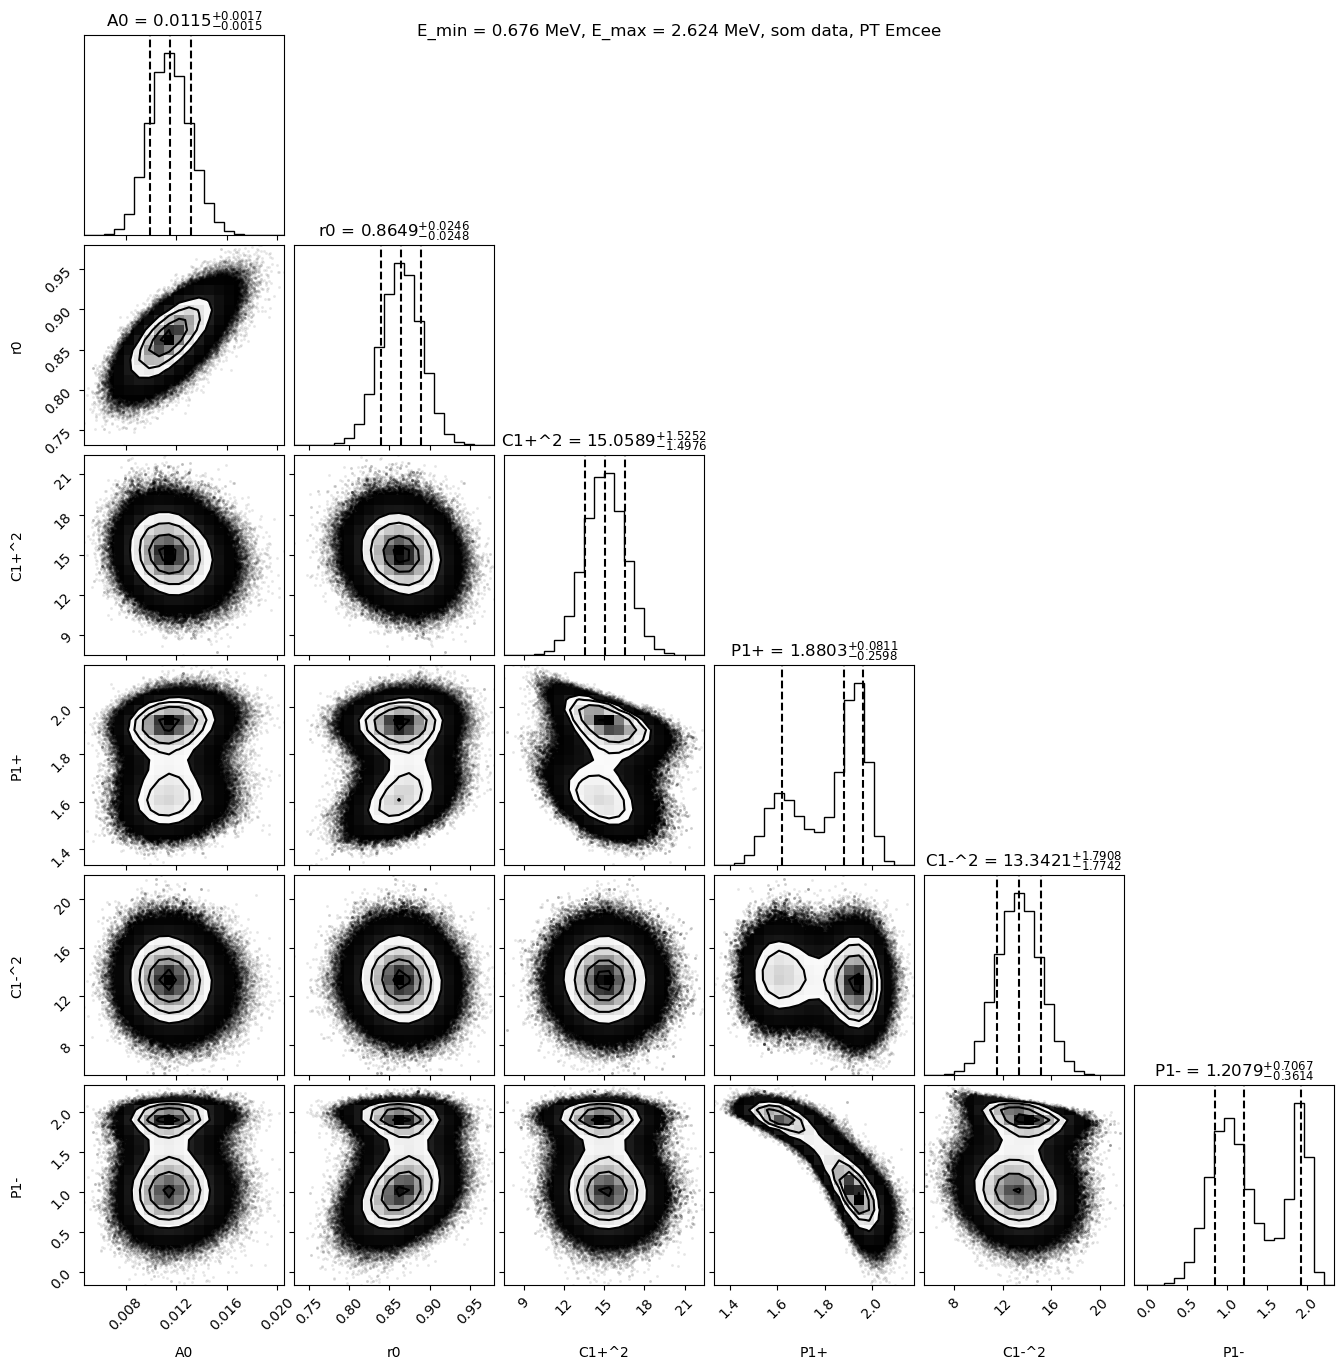

In [8]:
corner.corner(samples[:, :model.erp_dim], labels = labels[:model.erp_dim], quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle("E_min = {} MeV, E_max = {} MeV, {} data, PT Emcee".format(E_min, E_max, which_data))
plt.show()